In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./dataset"]).decode("utf8"))

images_sample
sample.csv
sample_submission.csv
test.json
train.json



In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (RandomTreesEmbedding,GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


import matplotlib.pyplot as plt


In [3]:
df = pd.read_json(open("./dataset/train.json", "r"))


In [4]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

In [5]:
num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
             "num_photos", "num_features", "num_description_words",
             "created_year", "created_month", "created_day"]
X = df[num_feats]
y = df["interest_level"]
X.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day
10,1.5,3,40.7145,-73.9425,3000,5,0,95,2016,6,24
10000,1.0,2,40.7947,-73.9667,5465,11,5,9,2016,6,12
100004,1.0,1,40.7388,-74.0018,2850,8,4,94,2016,4,17
100007,1.0,1,40.7539,-73.9677,3275,3,2,80,2016,4,18
100013,1.0,4,40.8241,-73.9493,3350,3,1,68,2016,4,28


In [6]:
df = X
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X = df

In [8]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)


In [ ]:
performance = []

# Lowest is at n_estimators = 60

for i in range(0,1):
    # Gradient Boosting + LR
    
    n_estimator = 5000

    grd = GradientBoostingClassifier(n_estimators=n_estimator)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression(solver='lbfgs', multi_class = 'multinomial')
    grd.fit(X_train, y_train)
    grd_enc.fit(grd.apply(X_train)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

    y_pred_grd_lm = grd_lm.predict_proba(
        grd_enc.transform(grd.apply(X_test)[:, :, 0]))
    tmp = log_loss(y_test, y_pred_grd_lm)
    performance.append(tmp)
    print(str(i) + ": " + str(tmp))
    #fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

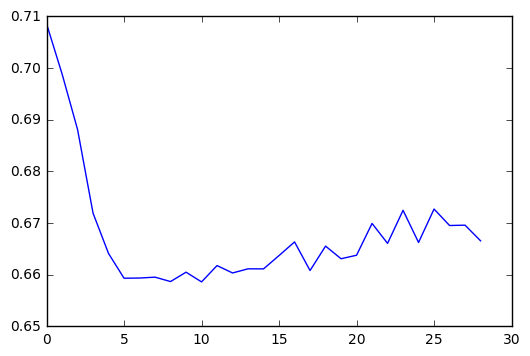

In [41]:
plt.plot(performance)
plt.show()

In [15]:
#clf = RandomForestClassifier(n_estimators=5000)
#0.62825882559964685
#clf = LogisticRegression(solver='lbfgs', multi_class = 'multinomial')
#clf = MLPClassifier(solver='lbfgs', max_iter=10000, verbose=True)
#0.75043775758055209
#clf = AdaBoostClassifier(n_estimators = 1000)
#1.Something


seed = 1
cart = DecisionTreeClassifier()
num_trees = 10000
clf = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.64782539636099101

In [10]:
df = pd.read_json(open("./dataset/test.json", "r"))
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
X = df[num_feats]


# Normalizing
df = X
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X = df


In [11]:
y = clf.predict_proba(X)

In [12]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{'high': 0, 'low': 1, 'medium': 2}

In [13]:
sub = pd.DataFrame()
df = pd.read_json(open("./dataset/test.json", "r"))
sub["listing_id"] = df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("submission_rf.csv", index=False)